In [3]:
library('Seurat')
library('stringr')
library('dplyr')
library('tidyr')
library('ggplot2')
library('pheatmap')
library('magrittr')
library('SingleCellExperiment')
library('ggrepel')
options(repr.plot.width = 7, repr.plot.height = 7) # set default plot size
options(jupyter.plot_mimetypes = 'image/svg+xml') # output SVG
options(ggrepel.max.overlaps = Inf)

## Load Seurat Objects (Primary Macs)

In [4]:
# set path to files 
prefix = '~'

In [5]:
load_seurat <- function(modality, lanes) {
    seurat <- list()
    for(sample in lanes) {
        # Load h5 files.
        filepath <- paste0(prefix,"/data/PrimaryMacs/", modality, "/",sample,"/filtered_feature_bc_matrix.h5")
        counts <- Read10X_h5(filepath)[['Gene Expression']]

        seuratObj <- CreateSeuratObject(counts, project = sample, assay = 'RNA')
        # Calculate the percentage of mitochondrial gene expression
        seuratObj <- PercentageFeatureSet(seuratObj, pattern = "^MT-", col.name = "percent.mt")
        
        colnames(seuratObj) <- paste0(sample, "_", colnames(seuratObj))
        seurat[[sample]] <- seuratObj
    }
    # Combine into one single data set.
    merged_obj <- merge( seurat[[1]], seurat[-1] )
    return (JoinLayers(merged_obj,  assay = "RNA"))
}

CRISPRi_lanes <- c('D1-1i', 'D1-2i', 'D1-3i', 'D1-4i', 'D2-1i', 'D2-2i', 'D2-3i')
CRISPRa_lanes <- c('D1-5a', 'D1-6a', 'D1-7a', 'D1-8a', 'D2-4a', 'D2-5a', 'D2-6a')

CRISPRi_seurat <- load_seurat("CRISPRi", CRISPRi_lanes)
CRISPRa_seurat <- load_seurat("CRISPRa", CRISPRa_lanes)

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matric

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


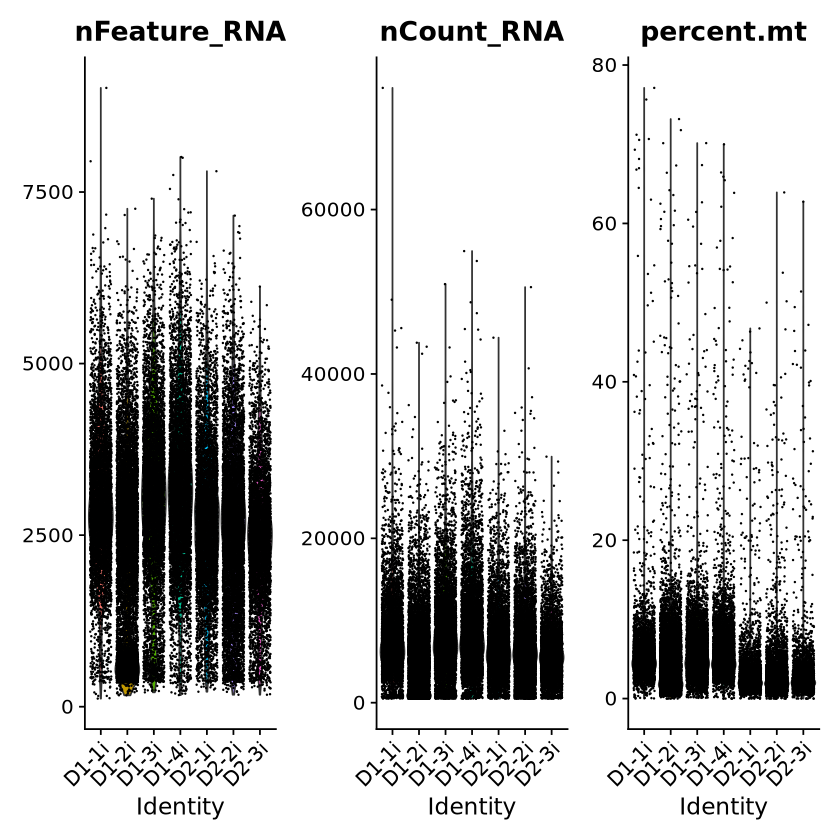

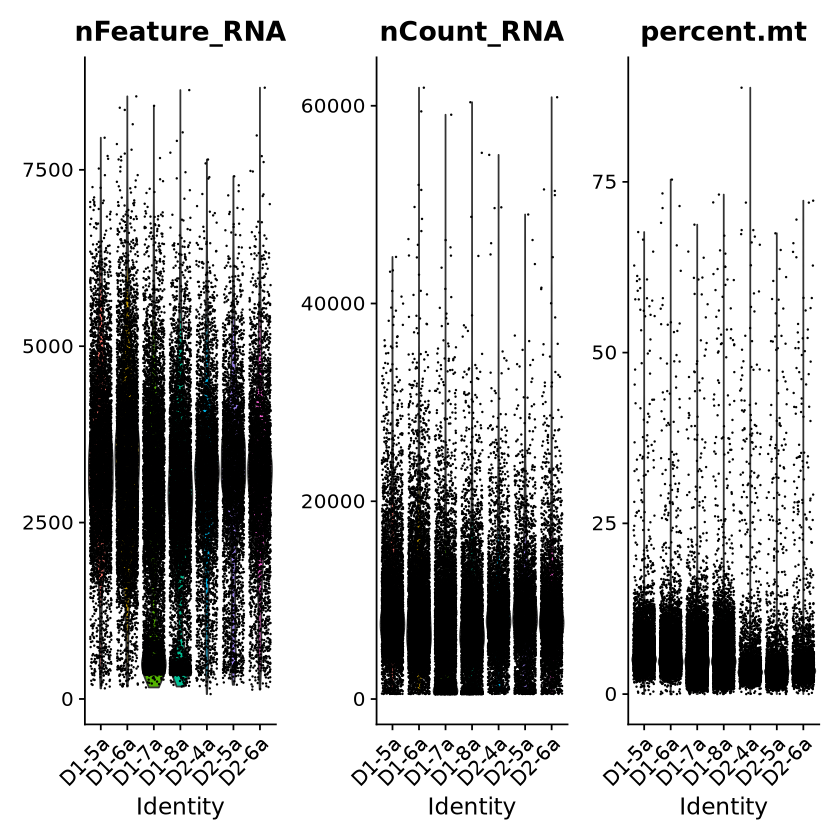

In [8]:
options(jupyter.plot_mimetypes = 'image/png')
VlnPlot(CRISPRi_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
VlnPlot(CRISPRa_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [9]:
# Filter cells
CRISPRi_seurat <- subset(CRISPRi_seurat, subset = percent.mt < 18 & nFeature_RNA > 1000 & nFeature_RNA < 7000 & nCount_RNA < 35000)
CRISPRa_seurat <- subset(CRISPRa_seurat, subset = percent.mt < 20 & nFeature_RNA > 1000 & nFeature_RNA < 7000 & nCount_RNA < 25000)

### Add guide assignments from simple_UMI_threshold script

In [10]:
add_guide_assignments <- function(seurat, modality, umi_cutoff) {
    # TODO: Need to handle cells with multiple guide assignments.
    guide_calls <- read.csv(paste0(modality, "_",umi_cutoff,"umi_NEW.csv"))
    # need to remove cells that didn't pass QC
    guide_calls <- guide_calls[guide_calls$cell_id %in% colnames(seurat),]
    # note subset reorders the cells to match guide_calls
    seurat <- subset(seurat, cells = guide_calls$cell_id)
    rownames(guide_calls) <- guide_calls$cell_id
    guide_calls <- guide_calls[colnames(seurat),]
    print(head(rownames(seurat@meta.data), 20) == head(guide_calls$cell_id, 20) )
    
    seurat[['guide_identity']] <- guide_calls$guide
    seurat[['Gene_Targeted']] <- str_split_fixed(guide_calls$guide, '_', 2)[,1]
    seurat[['donor']] <- str_split_fixed(seurat[[]]$orig.ident, '-', 2)[,1]
    # Set NT name and plotting variables. 
    seurat[[]] %<>% 
        mutate(Gene_Targeted = if_else(Gene_Targeted == 'Non-Targeting', "NT", Gene_Targeted))
    seurat[[]] %<>% 
        mutate(crispr = if_else(Gene_Targeted == 'NT', "NT", "Perturbed"))
    return(seurat)
}

In [24]:
#assign guides associated with each cutoff 
UMI_cutoffs = c(3, 5, 10, 15, 20, 30, 40)

for(cutoff in UMI_cutoffs){
    seurat_name_CRISPRi = paste0('CRISPRi_seurat',cutoff)
    assign(seurat_name_CRISPRi, add_guide_assignments(CRISPRi_seurat, "CRISPRi", cutoff))
    
    seurat_name_CRISPRa = paste0('CRISPRa_seurat',cutoff)
    assign(seurat_name_CRISPRa, add_guide_assignments(CRISPRa_seurat, "CRISPRa", cutoff))
}

 [1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE


In [26]:
seurat_objects_CRISPRi = c(CRISPRi_seurat3, CRISPRi_seurat5, CRISPRi_seurat10, CRISPRi_seurat15, CRISPRi_seurat20, CRISPRi_seurat30, CRISPRi_seurat40)
seurat_objects_CRISPRa = c(CRISPRa_seurat3, CRISPRa_seurat5, CRISPRa_seurat10, CRISPRa_seurat15, CRISPRa_seurat20, CRISPRa_seurat30, CRISPRa_seurat40)

seurat_objects_normalized_CRISPRi = lapply(seurat_objects_CRISPRi, NormalizeData)
seurat_objects_normalized_CRISPRa = lapply(seurat_objects_CRISPRa, NormalizeData)

Normalizing layer: counts



In [ ]:
CRISPRi_seurat3 <- seurat_objects_normalized_CRISPRi[[1]]
CRISPRi_seurat5 <- seurat_objects_normalized_CRISPRi[[2]]
CRISPRi_seurat10 <- seurat_objects_normalized_CRISPRi[[3]]
CRISPRi_seurat15 <- seurat_objects_normalized_CRISPRi[[4]]
CRISPRi_seurat20 <- seurat_objects_normalized_CRISPRi[[5]]
CRISPRi_seurat30 <- seurat_objects_normalized_CRISPRi[[6]]
CRISPRi_seurat40 <- seurat_objects_normalized_CRISPRi[[7]]

In [32]:
CRISPRa_seurat3 <- seurat_objects_normalized_CRISPRa[[1]]
CRISPRa_seurat5 <- seurat_objects_normalized_CRISPRa[[2]]
CRISPRa_seurat10 <- seurat_objects_normalized_CRISPRa[[3]]
CRISPRa_seurat15 <- seurat_objects_normalized_CRISPRa[[4]]
CRISPRa_seurat20 <- seurat_objects_normalized_CRISPRa[[5]]
CRISPRa_seurat30 <- seurat_objects_normalized_CRISPRa[[6]]
CRISPRa_seurat40 <- seurat_objects_normalized_CRISPRa[[7]]

In [33]:
# Only subset to genes that are both measured and in thet targetted gene list.
# This will remove NT as well. 

genesA <- table(CRISPRa_seurat5[["Gene_Targeted"]]$Gene_Targeted)
genesA <- as.list(genesA)
genesA[setdiff(names(genesA), rownames(CRISPRa_seurat))] <- NULL

genesI <- table(CRISPRi_seurat5[["Gene_Targeted"]]$Gene_Targeted)
genesI <- as.list(genesI)
genesI[setdiff(names(genesI), rownames(CRISPRi_seurat))] <- NULL

genesA <- names(genesA)
genesI <- names(genesI)

[1] "ABCA1"     "ABCA7"     "ABI3"      "ACTB"      "ADA2"      "ADAM10"   
  [7] "ADGRG1"    "AIF1"      "APOC1"     "APOE"      "APP"       "AXL"      
 [13] "BIN1"      "C1QA"      "C1QB"      "C1QC"      "C3AR1"     "C9orf72"  
 [19] "CCR2"      "CD14"      "CD180"     "CD19"      "CD1D"      "CD200R1"  
 [25] "CD226"     "CD300A"    "CD300C"    "CD300LB"   "CD300LF"   "CD33"     
 [31] "CD37"      "CD40"      "CD44"      "CD48"      "CD52"      "CD58"     
 [37] "CD68"      "CD69"      "CD80"      "CD81"      "CD86"      "CDKN2A"   
 [43] "CEMIP2"    "CHRNE"     "CLDN7"     "CLEC2B"    "CLEC2D"    "CLEC7A"   
 [49] "CLECL1"    "CLIC1"     "CLN3"      "CLU"       "CR1"       "CR2"      
 [55] "CSF1R"     "CSF2RA"    "CSF2RB"    "CSF3R"     "CTLA4"     "CTSB"     
 [61] "CTSH"      "CXCR3"     "CXCR4"     "DPYD"      "EPHA1"     "FCER1G"   
 [67] "FCGR1A"    "FCGR2A"    "FCGR2B"    "FCGR3A"    "FCGR3B"    "FERMT3"   
 [73] "FLT1"      "FOLR2"     "FPR1"      "FPR2"      "FPR3"      "GBA"      
 [79] "GPNMB"     "GPR141"    "GPR183"    "GPR65"     "GPR87"     "GRN"      
 [85] "HAVCR1"    "HEXA"      "HEXB"      "HLA-DRB5"  "ICAM1"     "ICAM3"    
 [91] "IFNGR1"    "IFNGR2"    "IL10"      "IL15"      "IL15RA"    "IL1R1"    
 [97] "IL1R2"     "IL1RN"     "IL21R"     "IL23A"     "IL2RA"     "IL2RG"    
[103] "IL6R"      "ILDR1"     "IRF5"      "IRF8"      "ITGA5"     "ITGAL"    
[109] "ITGAM"     "ITGAX"     "ITGB2"     "ITGB3"     "ITM2B"     "ITM2C"    
[115] "LAPTM5"    "LDLR"      "LDLRAD3"   "LILRA5"    "LILRB4"    "LPAR2"    
[121] "LPL"       "LRP1"      "LRP1B"     "LRP6"      "LRP8"      "LRRK2"    
[127] "LSR"       "LTBR"      "LYVE1"     "LYZ"       "MERTK"     "MMP9"     
[133] "MRC1"      "MRC2"      "MS4A4A"    "MS4A6A"    "NFATC1"    "NFATC2"   
[139] "NLRC4"     "NLRP3"     "NPC2"      "NRP1"      "NRP2"      "OLR1"     
[145] "P2RY12"    "P2RY13"    "P2RY6"     "PILRA"     "PILRB"     "PLAUR"    
[151] "PLCB3"     "PLCG2"     "PLEK"      "PTPRC"     "PTPRE"     "RYR1"     
[157] "S100A4"    "SCARB1"    "SCIMP"     "SELL"      "SELPLG"    "SERPINA1" 
[163] "SIGLEC5"   "SIGLEC7"   "SIGLEC9"   "SIRPA"     "SIRPB1"    "SLC16A5"  
[169] "SLC24A4"   "SLC52A1"   "SNCA"      "SORL1"     "SPI1"      "SPP1"     
[175] "SQSTM1"    "SUCNR1"    "SYK"       "TARDBP"    "TGFB1"     "TGFBI"    
[181] "TGFBR1"    "TGFBR2"    "TGFBR3"    "TLR10"     "TLR2"      "TLR4"     
[187] "TLR5"      "TLR7"      "TMEM106A"  "TMEM106B"  "TNFRSF10B" "TNFRSF13C"
[193] "TNFRSF1A"  "TP53"      "TREM1"     "TREM2"     "TREML2"    "TREML4"   
[199] "TYRO3"     "TYROBP"    "UNC13D"    "VCP"       "VDR"       "VENTX"    
[205] "VLDLR"

In [29]:
avg_cells_per_gene = c()
for(object in seurat_objects_normalized){
    mean = mean(table(object[["Gene_Targeted"]][,1]))
    avg_cells_per_gene = append(avg_cells_per_gene, mean)
}

In [30]:
avg_cells_per_gene

[1] 113.57

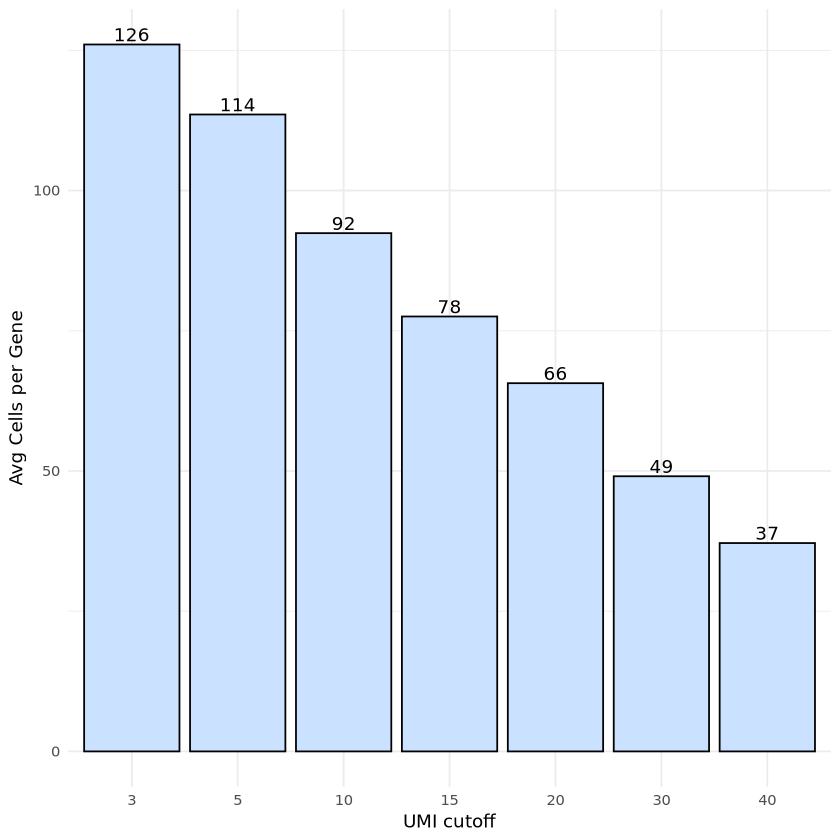

In [36]:
#avg number of cells per gene
df <- data.frame(UMI_cutoff = UMI_cutoffs,
                 Avg_cells_per_gene = avg_cells_per_gene)
df$UMI_cutoff <- as.factor(df$UMI_cutoff)

# Create a scatterplot
ggplot(df, aes(UMI_cutoff,avg_cells_per_gene)) + geom_col(fill = 'lightsteelblue1', color = 'black') + 
labs(x = "UMI cutoff", y = "Avg Cells per Gene") + theme_minimal() + geom_text(aes(label = round(avg_cells_per_gene)), position = position_dodge(width=0.9), vjust=-0.25)

In [69]:
# #save to RDS files so R script can read
saveRDS(CRISPRi_seurat3, file = "CRISPRi_seurat3_NEW.rds")
saveRDS(CRISPRi_seurat5, file = "CRISPRi_seurat5_NEW.rds")
saveRDS(CRISPRi_seurat10, file = "CRISPRi_seurat10_NEW.rds")
saveRDS(CRISPRi_seurat15, file = "CRISPRi_seurat15_NEW.rds")
saveRDS(CRISPRi_seurat20, file = "CRISPRi_seurat20_NEW.rds")
saveRDS(CRISPRi_seurat30, file = "CRISPRi_seurat30_NEW.rds")
saveRDS(CRISPRi_seurat40, file = "CRISPRi_seurat40_NEW.rds")

In [42]:
#save to RDS files so R script can read
saveRDS(CRISPRa_seurat3, file = "CRISPRa_seurat3_NEW.rds")
saveRDS(CRISPRa_seurat5, file = "CRISPRa_seurat5_NEW.rds")
saveRDS(CRISPRa_seurat10, file = "CRISPRa_seurat10_NEW.rds")
saveRDS(CRISPRa_seurat15, file = "CRISPRa_seurat15_NEW.rds")
saveRDS(CRISPRa_seurat20, file = "CRISPRa_seurat20_NEW.rds")
saveRDS(CRISPRa_seurat30, file = "CRISPRa_seurat30_NEW.rds")
saveRDS(CRISPRa_seurat40, file = "CRISPRa_seurat40_NEW.rds")

## Run glmGamPoi as a DE method that corrects for donor effect
Transferred this function to R script to run faster (file called run_glmgampoi.R)

### Read in output from R script

In [9]:
library(ggplot2)

In [43]:
stats_list = c('overall_stats_3umi_CRISPRi_NEW', 'overall_stats_5umi_CRISPRi_NEW', 'overall_stats_10umi_CRISPRi_NEW', 'overall_stats_15umi_CRISPRi_NEW', 
               'overall_stats_20umi_CRISPRi_NEW', 'overall_stats_30umi_CRISPRi_NEW')
Num_Significant_Genes = c()

for(stats in stats_list){
    stats <- read.csv(paste0(stats,'.csv'))
    num_genes = dim(na.omit(stats[stats$adj_pval <= 0.05,]))[1]
    Num_Significant_Genes = append(Num_Significant_Genes, num_genes)
    
}

In [44]:
Num_Significant_Genes

[1] 85 86 82 73 73 68

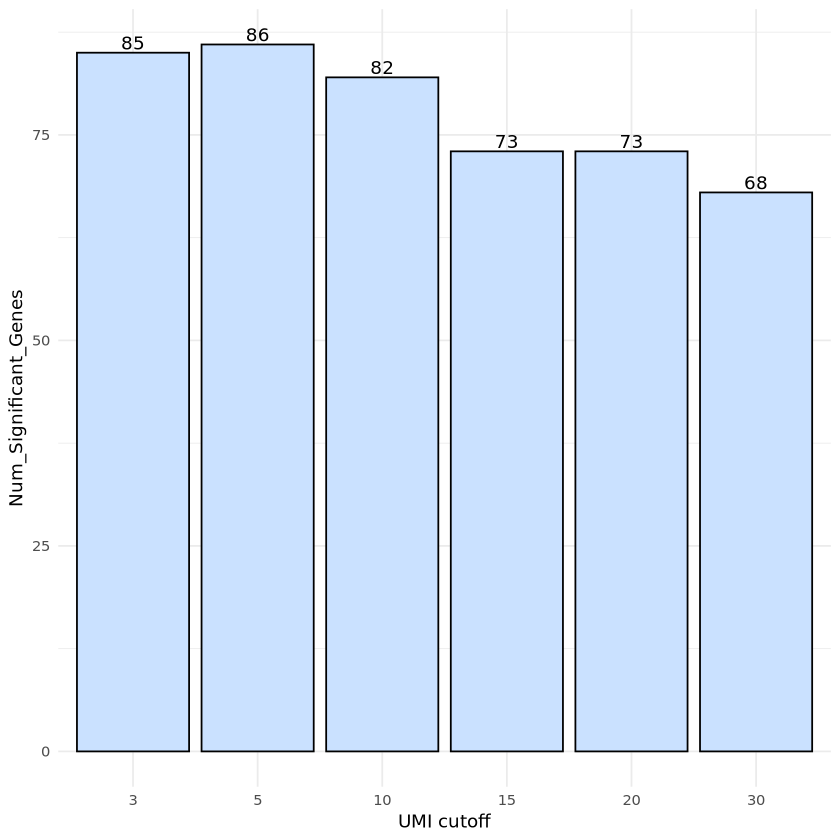

In [45]:
# num of significant target genes (cutoff = 0.05)
df <- data.frame(UMI_cutoff = c(3, 5, 10, 15, 20, 30), 
                 Num_Significant_Genes = Num_Significant_Genes)
df$UMI_cutoff <- as.factor(df$UMI_cutoff)
# Create a scatterplot
ggplot(df, aes(UMI_cutoff,Num_Significant_Genes)) + geom_col(fill = 'lightsteelblue1', color = 'black') + 
labs(x = "UMI cutoff", y = "Num_Significant_Genes") + theme_minimal() + geom_text(aes(label = Num_Significant_Genes), position = position_dodge(width=0.9), vjust=-0.25)

In [46]:
stats_list = c('overall_stats_3umi_CRISPRa_NEW', 'overall_stats_5umi_CRISPRa_NEW', 'overall_stats_10umi_CRISPRa_NEW', 'overall_stats_15umi_CRISPRa_NEW', 
               'overall_stats_20umi_CRISPRa_NEW', 'overall_stats_30umi_CRISPRa_NEW')
Num_Significant_Genes = c()

for(stats in stats_list){
    stats <- read.csv(paste0(stats,'.csv'))
    num_genes = dim(na.omit(stats[stats$adj_pval <= 0.05,]))[1]
    Num_Significant_Genes = append(Num_Significant_Genes, num_genes)
    
}

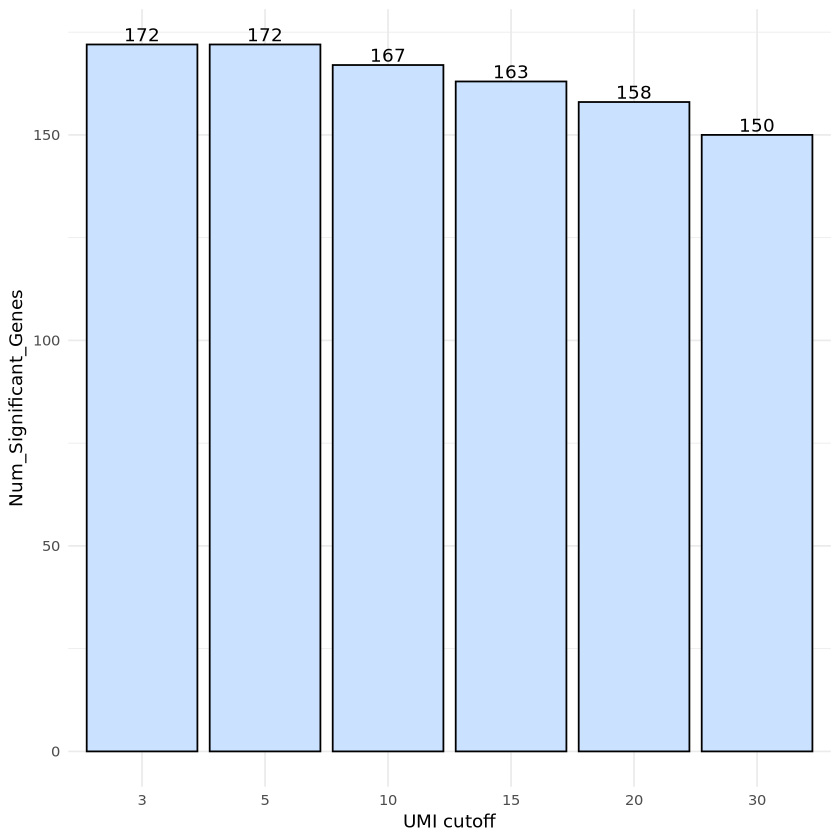

In [47]:
# num of significant target genes (cutoff = 0.05)
df <- data.frame(UMI_cutoff = c(3, 5, 10, 15, 20, 30), 
                 Num_Significant_Genes = Num_Significant_Genes)
df$UMI_cutoff <- as.factor(df$UMI_cutoff)
# Create a scatterplot
ggplot(df, aes(UMI_cutoff,Num_Significant_Genes)) + geom_col(fill = 'lightsteelblue1', color = 'black') + 
labs(x = "UMI cutoff", y = "Num_Significant_Genes") + theme_minimal() + geom_text(aes(label = Num_Significant_Genes), position = position_dodge(width=0.9), vjust=-0.25)

Choose 5 UMI as a cutoff for CRISPRi and 5 UMI as a cutoff for CRISPRa